Imports

In [201]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import random
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns


Data Importing

In [153]:
cwd = os.getcwd()
labels = pd.read_csv(cwd+"\\books_list.csv")

books_content = {}
language_list = ['Ancient Greek', 'French', 'Latin', 'Italian', 'German', 'English']
for index, row in labels.iterrows(): #['filename']:
	filename = row['filename']
	language = row['language']
	author = row['author']
	if language not in language_list:
		print(f"Skipping {filename} as its language '{language}' is not in the language list.")
		continue
	file_path = cwd + '\\saved_books\\' + filename + '.txt'
	if os.path.exists(file_path):
		with open(file_path, 'r') as file:
			content = file.read()
			books_content[filename] = {
				'content': content,
				'language': language,
				'author': author
			}
	else:
		print(f"File {filename} does not exist.")


Skipping friedrich_nietzsche as its language 'Danish' is not in the language list.


In [103]:
# This effectively removes the license text starting from the first two lines. 
license_start = """Updated editions will replace the previous one—the old editions will
be renamed."""

# Compile a regular expression pattern to match the start of the license
license_pattern = re.compile(re.escape(license_start), re.DOTALL)

for filename, book_data in books_content.items():
    match = license_pattern.search(book_data['content'])
    if match:
        # Find the start index of the match
        start_index = match.start()
        # Remove everything from the start of the license to the end of the content
        book_data['content'] = book_data['content'][:start_index]



Data Processing

In [154]:
# There were a few books that had underscores in weird formatting errors that I removed manually (ctrl+h)
# and I just want to make to make sure that's not going to bias things.
for filename, book_data in books_content.items():
	book_data['content'] = book_data['content'].replace('_', '')


In [155]:
# Initialize a list to store the new data
data = []

# Function to split content into sentences of up to 50 words, padding with underscores if needed
def split_sentences_simple(content):
    sentences = content.split('. ')
    split_sentences = []
    
    for sentence in sentences:
        words = sentence.split()
        for i in range(0, len(words), 50):
            sentence_chunk = words[i:i + 50]
            if len(sentence_chunk) < 50:
                sentence_chunk.extend(['_'] * (50 - len(sentence_chunk)))
            split_sentences.append(' '.join(sentence_chunk))
    
    return split_sentences

def split_sentences(content, max_words=50):
    words = content.split()
    sentences = []
    for i in range(0, len(words), max_words):
        sentence = words[i:i+max_words]
        if len(sentence) < max_words:
            sentence.extend(['_'] * (max_words - len(sentence)))
        sentences.append(' '.join(sentence))
    return sentences

# Collect sentences from books_content dictionary
for book in books_content.values(): ###########################################################
    # sentences = split_sentences_simple(book['content'])
    sentences = split_sentences(book['content'])
    for sentence in sentences:
        data.append({'sentence': sentence, 'language': book['language'], 'author': book['author']})

# Convert the data to a DataFrame
df_sentences = pd.DataFrame(data)

# Limit to 2000 sentences per language, roughly evenly distributed among authors
final_data = []

for language in df_sentences['language'].unique():
    language_df = df_sentences[df_sentences['language'] == language]
    authors = language_df['author'].unique()
    
    sentences_per_author = 2000 // len(authors)
    
    for author in authors:
        author_df = language_df[language_df['author'] == author]
        sampled_sentences = author_df.sample(n=sentences_per_author, replace=True)
        final_data.extend(sampled_sentences.to_dict(orient='records'))

# Convert the final_data to a DataFrame
final_df = pd.DataFrame(final_data)

# If there are any remaining slots to reach exactly 2000 per language, fill them
for language in final_df['language'].unique():
    current_count = len(final_df[final_df['language'] == language])
    if current_count < 2000:
        additional_sentences = df_sentences[df_sentences['language'] == language].sample(n=2000-current_count, replace=True)
        final_df = pd.concat([final_df, additional_sentences])

# Reset index
final_df.reset_index(drop=True, inplace=True)
print(final_df['language'].value_counts())
print(final_df['author'].value_counts())


Ancient Greek    2000
French           2000
Latin            2000
Italian          2000
German           2000
English          2000
Name: language, dtype: int64
Benedetto Croce            334
Dante Alighieri            334
Antonio Labriola           333
Giordano Bruno             333
Ferruccio Busoni           333
Machiavelli                333
Boethius                   287
Juvenal                    286
Ovid                       286
Benedictus Spinoza         286
Rene Descartes             285
Marcus Aurelius            285
Titus Lucretius Carus      285
Acton                      223
John Gunn                  223
George Stuart Fullerton    222
Herbert Cushman            222
Percy Bridgman             222
George Grote               222
Edwin Hatch                222
John Blackie               222
Edward Arnold              222
Michel de Montaigne        200
Voltaire                   200
Plato                      200
Antipope Hippolytus        200
Iamblichus                 200
Pl

In [106]:
print(final_df[:5])
print(final_df['sentence'][2])

                                            sentence       language     author
0  pieces, lamented, searched for, discovered or ...  Ancient Greek  Aristotle
1  that tragedy 'imitates good men' while comedy ...  Ancient Greek  Aristotle
2  is a nonsignificant composite sound, made up o...  Ancient Greek  Aristotle
3  indeed can all those kinds of quantity that ha...  Ancient Greek  Aristotle
4  is doubtless one of Aristotle's great services...  Ancient Greek  Aristotle
is a nonsignificant composite sound, made up of a mute and a Letter having a sound (a vowel or semivowel); for GR, without an A, is just as much a Syllable as GRA, with an A. The various forms of the Syllable also belong to the theory of metre. (3)


Word Embedding

In [156]:
def create_word_embeddings(df, min_occurrences=10): ######################################################
    # Split all sentences into words
    all_words = [word for sentence in df['sentence'] for word in sentence.split()]
    
    # Count the occurrences of each word
    word_counts = Counter(all_words)
    
    # Create a mapping for words to numbers, starting from 0
    word_to_number = {word: idx for idx, (word, count) in enumerate(word_counts.items()) if count >= min_occurrences}
    
    # Add an entry for the rare words (padding token)
    padding_token = '_'
    word_to_number[padding_token] = len(word_to_number)

    # Function to convert a sentence to its numeric representation
    def sentence_to_numbers(sentence):
        return [word_to_number.get(word, word_to_number[padding_token]) for word in sentence.split()]
    
    # Apply the conversion to the DataFrame
    df['sentence_numeric'] = df['sentence'].apply(sentence_to_numbers)
    
    return df, word_to_number

final_df = final_df.sample(frac=1).reset_index(drop=True)
# Apply the function to create word embeddings and replace rare words
embedded_df, word_to_number = create_word_embeddings(final_df)
# Print the word to number mapping for reference
print("Word to Number Mapping:")
print(word_to_number)
print(embedded_df)

Word to Number Mapping:
{'believe': 0, 'The': 1, 'soul': 2, 'no': 3, 'less': 4, 'is': 5, 'abroad': 7, 'and': 8, 'dies': 9, 'More': 10, 'quickly': 11, 'far,': 12, 'more': 13, 'dissolved': 14, 'Back': 15, 'to': 16, 'its': 17, 'primal': 18, 'bodies,': 19, 'when': 20, 'withdrawn': 21, 'From': 22, 'out': 23, "man's": 24, 'members': 25, 'it': 26, 'has': 27, 'gone': 28, 'away.': 29, 'For,': 30, 'sure,': 31, 'if': 32, 'body': 33, 'of': 35, 'the': 36, 'same': 37, 'Like': 38, 'as': 39, 'a': 40, 'from': 43, 'some': 44, 'cause,': 45, 'And': 46, 'word': 49, 'or': 50, 'systematic': 52, 'parts,': 54, 'geometrical': 55, 'development': 56, 'many': 59, 'other': 60, 'stage': 61, 'must': 63, 'derive': 64, 'their': 65, 'comic': 66, 'force': 67, 'art': 69, 'probably': 71, 'in': 73, 'setting': 74, 'before': 75, 'us': 76, 'an': 77, 'obvious': 78, 'arrangement': 80, 'imagination.': 81, 'was': 83, 'greatly': 84, 'with': 86, 'signs,': 89, 'which': 90, 'saying': 92, 'that': 93, 'he': 94, 'believed': 95, 'each': 9

In [108]:
def split_by_author(df, test_size=0.15):
    authors = df['author'].unique()
    np.random.shuffle(authors)
    # Calculate the total number of sentences
    total_sentences = len(df)
    # Calculate the number of sentences needed for the test set
    test_sentences_needed = int(total_sentences * test_size)

    test_data = pd.DataFrame()
    train_data = pd.DataFrame()
    # Select authors for the test set until the desired number of sentences is reached
    current_test_sentences = 0
    test_authors = []
    for author in authors:
        author_sentences = df[df['author'] == author]
        num_sentences = len(author_sentences)
        if current_test_sentences + num_sentences <= test_sentences_needed:
            test_authors.append(author)
            test_data = pd.concat([test_data, author_sentences])
            current_test_sentences += num_sentences
        else:
            train_data = pd.concat([train_data, author_sentences])
    # Add the remaining authors to the train set
    remaining_authors = set(authors) - set(test_authors)
    for author in remaining_authors:
        train_data = pd.concat([train_data, df[df['author'] == author]])
    # Reset index
    test_data.reset_index(drop=True, inplace=True)
    train_data.reset_index(drop=True, inplace=True)
    return train_data, test_data



Model Declaration

In [109]:
language_to_idx = {language: idx for idx, language in enumerate(embedded_df['language'].unique())}
idx_to_language = {idx: language for language, idx in language_to_idx.items()}

# Add numerical labels for languages
embedded_df['language_label'] = embedded_df['language'].map(language_to_idx)

# Custom Dataset class
class SentenceDataset(Dataset):
    def __init__(self, df):
        self.sentences = df['sentence_numeric'].values
        self.labels = df['language_label'].values

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = torch.tensor(self.sentences[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sentence, label

# Create datasets and dataloaders
train_df, test_df = split_by_author(embedded_df)

most_common_language = train_df['language'].value_counts().idxmax()
most_common_language_count = train_df['language'].value_counts().max()

print(f"The most common language in the training set is '{most_common_language}' with {most_common_language_count} occurrences.")


train_dataset = SentenceDataset(train_df)
test_dataset = SentenceDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Neural Network
class LanguageClassifier(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size, dropout_prob=0.5):
        super(LanguageClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden2_size, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

The most common language in the training set is 'Latin' with 4000 occurrences.


Model Usage and Analysis

In [110]:
# Hyperparameters
input_size = 50  # Assuming each sentence is converted to a vector of 50 word indices
hidden1_size = 30
hidden2_size = 10
output_size = len(language_to_idx)

# Initialize model, loss function, and optimizer
model = LanguageClassifier(input_size, hidden1_size, hidden2_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 40

def calculate_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sentences, labels in loader:
            sentences = sentences.view(sentences.size(0), -1).float()
            labels = labels.long()
            outputs = model(sentences)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for sentences, labels in train_loader:
        sentences = sentences.view(sentences.size(0), -1).float()  # Convert to float32
        optimizer.zero_grad()
        outputs = model(sentences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * sentences.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Calculate training accuracy
    train_accuracy = calculate_accuracy(train_loader)
    
    # Calculate testing accuracy
    test_accuracy = calculate_accuracy(test_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

# Final Evaluation
model.eval()
correct = 0
total = 0
example_predictions = []
with torch.no_grad():
    for sentences, labels in test_loader:
        sentences = sentences.view(sentences.size(0), -1).float()
        labels = labels.long()
        
        outputs = model(sentences)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        example_predictions.extend(zip(outputs.cpu().numpy(), predicted.cpu().numpy(), labels.cpu().numpy()))

accuracy = 100 * correct / total
print(f"Final Test Accuracy: {accuracy:.2f}%")
print(f"Language order: {idx_to_language}")

for i, (outputs, pred, actual) in enumerate(example_predictions[:10]):
    print(f"Percentages: {outputs}, Predicted: {pred} ({idx_to_language[pred]}), Actual: {actual} ({idx_to_language[actual]})")

Epoch 1/40, Loss: 7.2337, Train Accuracy: 19.48%, Test Accuracy: 0.00%
Epoch 2/40, Loss: 1.7913, Train Accuracy: 19.48%, Test Accuracy: 0.00%
Epoch 3/40, Loss: 1.7866, Train Accuracy: 19.48%, Test Accuracy: 0.00%
Epoch 4/40, Loss: 1.7882, Train Accuracy: 19.48%, Test Accuracy: 0.00%
Epoch 5/40, Loss: 1.7869, Train Accuracy: 19.48%, Test Accuracy: 0.00%
Epoch 6/40, Loss: 1.7870, Train Accuracy: 19.48%, Test Accuracy: 0.00%
Epoch 7/40, Loss: 1.7869, Train Accuracy: 19.48%, Test Accuracy: 0.00%
Epoch 8/40, Loss: 1.7867, Train Accuracy: 19.48%, Test Accuracy: 0.00%
Epoch 9/40, Loss: 1.7868, Train Accuracy: 19.48%, Test Accuracy: 0.00%
Epoch 10/40, Loss: 1.7867, Train Accuracy: 19.48%, Test Accuracy: 0.00%
Epoch 11/40, Loss: 1.7870, Train Accuracy: 19.48%, Test Accuracy: 0.00%
Epoch 12/40, Loss: 1.7877, Train Accuracy: 19.48%, Test Accuracy: 0.00%
Epoch 13/40, Loss: 1.7869, Train Accuracy: 19.48%, Test Accuracy: 0.00%
Epoch 14/40, Loss: 1.7869, Train Accuracy: 19.48%, Test Accuracy: 0.00%
E

Linear Classifier Attempt:

In [113]:
class LinearClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        x = self.linear(x)  # No activation function here
        return x
    
input_size = 50  # Assuming each sentence is converted to a vector of 50 word indices
output_size = len(language_to_idx)

# Initialize model, loss function, and optimizer
model = LinearClassifier(input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def calculate_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sentences, labels in loader:
            sentences = sentences.view(sentences.size(0), -1).float()
            labels = labels.long()
            outputs = model(sentences)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for sentences, labels in train_loader:
        sentences = sentences.view(sentences.size(0), -1).float()  # Convert to float32
        optimizer.zero_grad()
        outputs = model(sentences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * sentences.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Calculate training accuracy
    train_accuracy = calculate_accuracy(train_loader)
    
    # Calculate testing accuracy
    test_accuracy = calculate_accuracy(test_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

# Final Evaluation
model.eval()
correct = 0
total = 0
example_predictions = []
with torch.no_grad():
    for sentences, labels in test_loader:
        sentences = sentences.view(sentences.size(0), -1).float()
        labels = labels.long()
        
        outputs = model(sentences)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        example_predictions.extend(zip(outputs.cpu().numpy(), predicted.cpu().numpy(), labels.cpu().numpy()))

accuracy = 100 * correct / total
print(f"Final Test Accuracy: {accuracy:.2f}%")
print(f"Language order: {idx_to_language}")

for i, (_, pred, actual) in enumerate(example_predictions[:10]):
    print(f"Predicted: {pred} ({idx_to_language[pred]}), Actual: {actual} ({idx_to_language[actual]})")

Epoch 1/40, Loss: 460.2916, Train Accuracy: 19.23%, Test Accuracy: 11.21%
Epoch 2/40, Loss: 295.8393, Train Accuracy: 17.17%, Test Accuracy: 18.26%
Epoch 3/40, Loss: 304.7859, Train Accuracy: 17.76%, Test Accuracy: 16.35%
Epoch 4/40, Loss: 289.7219, Train Accuracy: 17.96%, Test Accuracy: 11.96%
Epoch 5/40, Loss: 295.9683, Train Accuracy: 17.07%, Test Accuracy: 18.02%
Epoch 6/40, Loss: 295.3578, Train Accuracy: 17.67%, Test Accuracy: 12.07%
Epoch 7/40, Loss: 292.7065, Train Accuracy: 17.59%, Test Accuracy: 17.10%
Epoch 8/40, Loss: 295.9728, Train Accuracy: 15.98%, Test Accuracy: 21.43%
Epoch 9/40, Loss: 309.6895, Train Accuracy: 17.13%, Test Accuracy: 18.49%
Epoch 10/40, Loss: 295.8943, Train Accuracy: 17.83%, Test Accuracy: 14.50%
Epoch 11/40, Loss: 303.0084, Train Accuracy: 18.39%, Test Accuracy: 14.10%
Epoch 12/40, Loss: 307.5680, Train Accuracy: 16.01%, Test Accuracy: 20.97%
Epoch 13/40, Loss: 335.4236, Train Accuracy: 15.69%, Test Accuracy: 20.51%
Epoch 14/40, Loss: 292.9209, Train

---
<h1> Resetting and changing methods to use good embeddings. </h1> 

---------------------------------

<h3> Load GloVe </h3>

In [157]:
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Example usage
glove_file_path = cwd + '/glove.42B.300d.txt'  
embeddings_index = load_glove_embeddings(glove_file_path)
print(f"Loaded {len(embeddings_index)} word vectors.")

Loaded 1917495 word vectors.


In [158]:
def inspect_embeddings_index(embeddings_index, num_items=5):
    for i, (word, vector) in enumerate(embeddings_index.items()):
        if i >= num_items:
            break
        print(f"Word: {word}\nVector: {vector[:10]}\n     Length of vector: {len(vector)}")

print(f"Size of the vocabulary: {len(embeddings_index)}")

inspect_embeddings_index(embeddings_index, num_items=4)

Size of the vocabulary: 1917495
Word: ,
Vector: [ 0.18378  -0.12123  -0.11987   0.015227 -0.19121  -0.066074 -2.9876
  0.80795   0.067338 -0.13184 ]
     Length of vector: 300
Word: the
Vector: [-0.20838  -0.14932  -0.017528 -0.028432 -0.060104 -0.2646   -4.1445
  0.62932   0.33672  -0.43395 ]
     Length of vector: 300
Word: .
Vector: [ 1.0876e-01  2.2438e-03  2.2213e-01 -1.2102e-01 -4.8959e-02  1.8135e-02
 -3.8174e+00 -3.2631e-02 -6.2594e-01 -5.1898e-01]
     Length of vector: 300
Word: and
Vector: [-0.09611 -0.25788 -0.3586  -0.32887  0.5795  -0.51774 -4.1582  -0.11371
 -0.10848 -0.48885]
     Length of vector: 300


So our word representation is currently in 300 dimensional space with each token having a unique meaning. I'm going to try to crush the dimensionality down to hopefully keep the parts with the most variability (hopefully syntax).

In [203]:
# Convert the embeddings index to a DataFrame using NumPy for preallocation which is also for memory efficency
def embeddings_to_df_optimized(embeddings_index):
    words = list(embeddings_index.keys())
    vectors = np.array(list(embeddings_index.values()))
    print("Created the NP arrays")
    
    # Create a DataFrame
    df = pd.DataFrame(vectors, index=words)
    print("Created the DF")
    return df

# Perform PCA on the embeddings
# def perform_pca(embeddings_df, n_components=50):
#     pca = PCA(n_components=n_components)
#     reduced_embeddings = pca.fit_transform(embeddings_df)
#     return reduced_embeddings, pca


# PCA is much too memory inefficent, hopefully incremental will work better
def perform_incremental_pca(embeddings_df, n_components=50, batch_size=None): #############################
    ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
    reduced_embeddings = ipca.fit_transform(embeddings_df)
    return reduced_embeddings, ipca

# Convert embeddings index to DataFrame
embeddings_df = embeddings_to_df_optimized(embeddings_index)

# Perform PCA ##############################################################################################
embedding_dim = 5
reduced_embeddings, pca = perform_incremental_pca(embeddings_df, n_components=embedding_dim)

# Put it back into a data frame
df = pd.DataFrame(reduced_embeddings, index=embeddings_df.index)

# Print the shape of the original and reduced embeddings
print(f"Original embeddings shape: {embeddings_df.shape}")
print(f"Reduced embeddings shape: {reduced_embeddings.shape}")

# Inspect the first few rows of the reduced embeddings
print(df.head())

Created the NP arrays
Created the DF
Original embeddings shape: (1917495, 300)
Reduced embeddings shape: (1917495, 5)
            0         1         2         3         4
,   -5.099487 -2.398560  0.657601  0.670511 -1.677739
the -6.497086 -0.441369 -0.135343  0.336630 -2.194523
.   -5.535259 -2.061961 -0.428478 -0.176906 -0.431132
and -6.737930 -0.082094  0.372389  0.853790 -1.149390
to  -6.617531 -0.783848 -0.473341 -0.350100 -1.529169


Rewriting the code to find sentences to hopefully make it easier to change in the future (I might want to use some sort of NLP to find sentence borders instead of grabbing things like roman numerals)

In [204]:
# Function to split text into sentences
def find_sentences(text):
    # Simple sentence split based on punctuation
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    return sentences

# Function to embed words of a sentence in the new embedding space
def embed_sentence(sentence, embedding_df):
    words = sentence.split()
    embeddings = []
    for word in words:
        if word in embedding_df.index:
            embeddings.append(embedding_df.loc[word].values)
        else:
            embeddings.append(np.zeros(embedding_df.shape[1]))  # If word not in embedding, use zero vector
    return np.array(embeddings)

# Function to process the book texts by embedding a fraction of their sentences
def process_books(book_dict, embedding_df, fraction=1.0):
    for book_title, book_info in book_dict.items():
        book_text = book_info['content']
        sentences = find_sentences(book_text)
        embedded_sentences = [embed_sentence(sentence, embedding_df) for sentence in sentences]
        
        # Select a fraction of the sentences to keep
        num_sentences_to_keep = int(len(embedded_sentences) * fraction)
        selected_sentences = np.random.choice(embedded_sentences, num_sentences_to_keep, replace=False)
        
        # Add the embedded sentences to the original dictionary
        book_info['embedded_sentences'] = selected_sentences.tolist()
process_books(books_content, df)

C:\Users\caust\AppData\Local\Temp\ipykernel_36756\970419909.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  selected_sentences = np.random.choice(embedded_sentences, num_sentences_to_keep, replace=False)


Now I'm going to find roughly equal numbers of books per author as before.

In [205]:
def organize_sentences_with_metadata(books_content):
    organized_sentences = []

    for book_info in books_content.values():
        language = book_info['language']
        author = book_info['author']
        original_sentences = book_info['content'].split('. ')  # Assuming sentences are split by '. '
        embedded_sentences = book_info['embedded_sentences']
        
        for orig_sentence, emb_sentence in zip(original_sentences, embedded_sentences):
            organized_sentences.append({
                'language': language,
                'author': author,
                'original_sentence': orig_sentence,
                'embedding': emb_sentence
            })
    
    return organized_sentences

# Function to sample sentences and create a dataset
def create_dataset(books_content, fraction=0.25):
    organized_sentences = organize_sentences_with_metadata(books_content)
    
    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(organized_sentences)
    
    # Calculate the number of sentences to sample
    num_sentences_to_sample = int(len(df) * fraction)
    
    # Sample sentences evenly distributed by language and author
    sampled_df = df.groupby(['language', 'author']).apply(lambda x: x.sample(frac=fraction)).reset_index(drop=True)
    
    # Prepare the final DataFrame
    return sampled_df

sampled_dataset = create_dataset(books_content, fraction=1)

# Cuts the number of sentences down to the author with the least in here (should be 25% of the length of the shortest book)
def adjust_to_minimum_sentences_per_author(sampled_df):
    # Find the minimum number of sentences for any author
    min_sentences = sampled_df.groupby('author').size().min()
    print("The number of sentences per author is", min_sentences)
    
    # Reduce the number of sentences for each author to this minimum
    adjusted_df = sampled_df.groupby('author').apply(lambda x: x.sample(n=min_sentences)).reset_index(drop=True)
    
    return adjusted_df
adjusted_dataset = adjust_to_minimum_sentences_per_author(sampled_dataset)

def pad_or_truncate_embeddings(embeddings, max_length, embedding_dim=50):
    padded_embeddings = []
    for emb in embeddings:
        if len(emb) == 0 or len(emb.shape) != 2:
            # Replace empty or non-2D embeddings with zero vectors of the required size
            emb = np.zeros((max_length, embedding_dim))
        elif len(emb) > max_length:
            emb = emb[:max_length]
        else:
            pad_width = max_length - len(emb)
            emb = np.pad(emb, ((0, pad_width), (0, 0)), mode='constant')
        padded_embeddings.append(emb)
    return np.array(padded_embeddings)


sentence_lengths = adjusted_dataset['embedding'].apply(len)
upper_quartile_length = int(np.percentile(sentence_lengths, 75))
max_length = max(adjusted_dataset['embedding'].apply(len))
max_length = 50

padded_embeddings = pad_or_truncate_embeddings(adjusted_dataset['embedding'].values, max_length, embedding_dim)
# Verify the shape of padded embeddings
print(f"Shape of padded embeddings: {padded_embeddings.shape}")
# Flatten them to make sure
flattened_embeddings = padded_embeddings.reshape(padded_embeddings.shape[0], -1)
print(f"Shape of flattened embeddings: {flattened_embeddings.shape}")

# Convert padded embeddings to list to match DataFrame structure
adjusted_dataset['embedding'] = list(flattened_embeddings)

embedding_shapes = adjusted_dataset['embedding'].apply(lambda x: x.shape)
print(f"Unique embedding shapes: {embedding_shapes.unique()}")

The number of sentences per author is 287
Shape of padded embeddings: (16646, 50, 5)
Shape of flattened embeddings: (16646, 250)
Unique embedding shapes: [(250,)]


In [206]:
def split_dataset_by_author(df):
    train_indices = []
    test_indices = []
    
    authors_per_language = {}
    for language in df['language'].unique():
        authors = df[df['language'] == language]['author'].unique()
        authors_per_language[language] = list(authors)
    
    # Determine the minimum number of authors across all languages
    min_authors = min(len(authors) for authors in authors_per_language.values())
    
    # Ensure there is at least one author in both training and test sets for each language
    num_train_authors = min_authors // 2
    if num_train_authors < 1:
        raise ValueError("Not enough authors to create a balanced train/test split")
    
    for language, authors in authors_per_language.items():
        train_authors = random.sample(authors, num_train_authors)
        test_authors = [author for author in authors if author not in train_authors]
        
        train_indices.extend(df[(df['language'] == language) & (df['author'].isin(train_authors))].index)
        test_indices.extend(df[(df['language'] == language) & (df['author'].isin(test_authors))].index)
    
    train_df = df.loc[train_indices].reset_index(drop=True)
    test_df = df.loc[test_indices].reset_index(drop=True)
    
    return train_df, test_df

Let's try XGBoost, I expect this may overfit significantly, though hopefully the dimension reduction and some parameters could keep it from being too bad.

Test Accuracy: 19.20%
Training Accuracy: 90.96%
True: Ancient Greek, Predicted: English
True: Ancient Greek, Predicted: Ancient Greek
True: Ancient Greek, Predicted: German
True: Ancient Greek, Predicted: Italian
True: Ancient Greek, Predicted: Latin


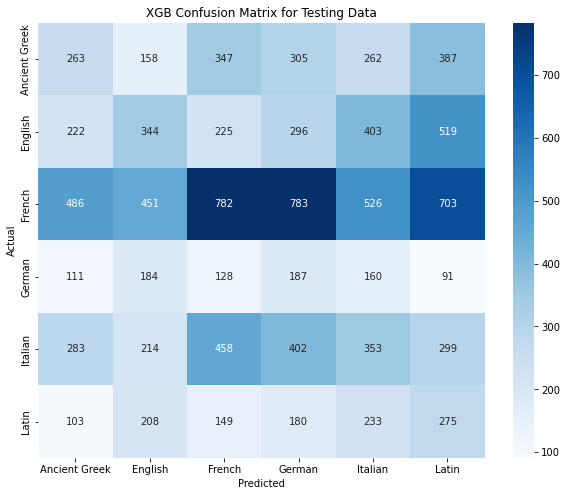

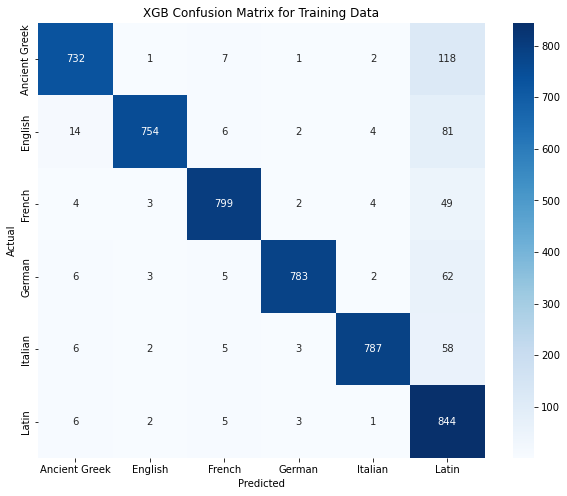

In [210]:
# embedding_shapes = adjusted_dataset['embedding'].apply(lambda x: x.shape)
# print(f"Unique embedding shapes: {embedding_shapes.unique()}")

X = np.stack(adjusted_dataset['embedding'].values)
y = adjusted_dataset['language'].values

# Encode the language labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Use the author specific splitting
train_df, test_df = split_dataset_by_author(adjusted_dataset)
# Extract the individual components for training set
X_train = np.stack(train_df['embedding'].values)
y_train = pd.factorize(train_df['language'])[0]
# Extract the individual components for test set
X_test = np.stack(test_df['embedding'].values)
y_test = pd.factorize(test_df['language'])[0]

# Create an XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_))

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%")

y_pred_train = model.predict(X_train.reshape(X_train.shape[0], -1))
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")


# Print the classification results
for i in range(len(y_test)):
    if i < 5:
        print(f"True: {label_encoder.inverse_transform([y_test[i]])[0]}, Predicted: {label_encoder.inverse_transform([y_pred[i]])[0]}")
    else:
        continue

# Plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, labels, title):
    conf_mat = confusion_matrix(y_true, y_pred)
    conf_mat_df = pd.DataFrame(conf_mat, index=labels, columns=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_test, y_pred, labels, "XGB Confusion Matrix for Testing Data")
plot_confusion_matrix(y_train, y_pred_train, labels, "XGB Confusion Matrix for Training Data")



Lets also try just a linear classifier:

Logistic Regression Training Accuracy: 39.90%
Logistic Regression Test Accuracy: 19.56%


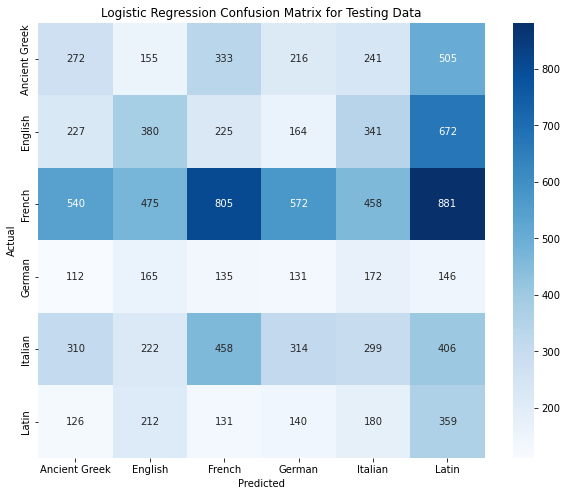

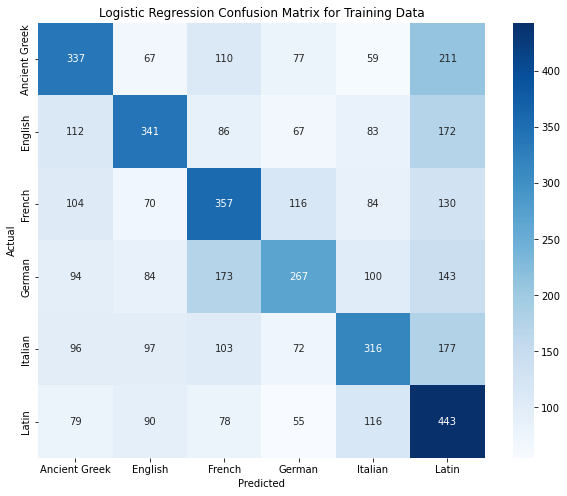

In [212]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Make predictions with the Logistic Regression model
y_train_pred_log_reg = log_reg.predict(X_train.reshape(X_train.shape[0], -1))
y_test_pred_log_reg = log_reg.predict(X_test.reshape(X_test.shape[0], -1))

# Evaluate the Logistic Regression model
train_accuracy_log_reg = accuracy_score(y_train, y_train_pred_log_reg)
test_accuracy_log_reg = accuracy_score(y_test, y_test_pred_log_reg)
print(f"Logistic Regression Training Accuracy: {train_accuracy_log_reg * 100:.2f}%")
print(f"Logistic Regression Test Accuracy: {test_accuracy_log_reg * 100:.2f}%")



# Labels for confusion matrix
labels = label_encoder.inverse_transform(np.arange(len(label_encoder.classes_)))


# Confusion matrix for testing data
plot_confusion_matrix(y_test, y_test_pred_log_reg, labels, "Logistic Regression Confusion Matrix for Testing Data")
# Confusion matrix for training data
plot_confusion_matrix(y_train, y_train_pred_log_reg, labels, "Logistic Regression Confusion Matrix for Training Data")